# Import Dependencies

In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchsummary import summary
from google.colab import drive
from google.colab.patches import cv2_imshow
from tqdm.auto import tqdm


# Mount google drive

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Note:** Please Add Dataset inside Google Drive.




In [ ]:
# Setting path to the datasets root folder
dataset_root_dir = '/content/drive/My Drive/Datasets/'

# Dataset folder structure

In [ ]:
!ls -F '/content/drive/My Drive/Datasets/'

Batch-1/  Batch-2/  Batch-3/  Best-Models/


In [ ]:
print("Batch-1/ ")
!ls -F -X '/content/drive/My Drive/Datasets/Batch-1'
print("\nBatch-2/ ")
!ls -F -X '/content/drive/My Drive/Datasets/Batch-2'
print("\nBatch-3/ ")
!ls -F -X '/content/drive/My Drive/Datasets/Batch-3'

Batch-1/ 
seedsegment/  seedsplit/

Batch-2/ 
NormalRoomLighting/  seedcropped/  seedsegment/  NormalRoomLight_annotation.csv

Batch-3/ 
LightBox/  seedcropped/  seedsegment/  LightBox_annotation.csv


**Note:**

To facilitate comparison, we generated two variations of individual seed images for both Batch-2 and Batch-3. In the initial version, images were exclusively cropped according to the provided bounding box coordinates. The resultant cropped images are stored within a directory named "seedcropped." Conversely, in the secondary version, akin to the images within Batch-1, the images underwent cropping and resizing to dimensions of 256 pixels by 256 pixels. These modified images are saved in a directory named "seedsegment."

In [ ]:
def extract_seed_image(annotations_csv, resize=True):
  print("Extracting images...")
  # Read the CSV file
  seed_df = pd.read_csv(annotations_csv)

  for index, row in seed_df.iterrows():
    # Get all image variables
    img_path = row["file_name"].rsplit('.')[0] + '.JPG'
    x_min, y_min, x_max, y_max = row["x_min"], row["y_min"], row["x_max"], row["y_max"]
    class_label = 'GoodSeed' if row["bbox_label"] == 'GOOD' else 'BadSeed' if row["bbox_label"] == 'BAD' else 'Labelling error' # Ensuring each sample in the csv is labelled correctly.

    # Read the image file
    image = cv2.imread(img_path)


    # Crop the image using the given bounds
    cropped_image = image[y_min:y_max, x_min:x_max].copy()

    if resize:
      # Resize the cropped image to 256x256
      resized_image = cv2.resize(cropped_image, (256, 256), interpolation=cv2.INTER_AREA)
      folder_name = 'seedsegment'
    else:
      folder_name = 'seedcropped'

    # Specify path to save the extracted image. Batch-<num>/<folder_name>/test/<class-cabel>
    data_dir = os.path.join(os.path.dirname(annotations_csv) , f'{folder_name}/test/{class_label}')

    # Create new folders if they don't exist on the path
    if not os.path.exists(data_dir):
      os.makedirs(data_dir)

    # Formatting the image name to <label>test<index>.jpg E.g., goodtest0.jpg, badtest12.jpg
    image_name = f'{row["bbox_label"].lower()}test{index}.jpg'

    if resize:
      # Save the extracted image to specified folder E.g. Batch-2/seedsegment/test/GoodSeed/goodtest0.jpg
      cv2.imwrite(f'{data_dir}/{image_name}', resized_image)
    else:
      # Save the extracted image to specified folder E.g. Batch-2/seedcropped/test/GoodSeed/goodtest0.jpg
      cv2.imwrite(f'{data_dir}/{image_name}', cropped_image)

  print(f'Extracted images saved at: {os.path.dirname(data_dir)}/')
  print("Individual seed image extraction completed.")


In [ ]:
# Setting paths to the annotation files
batch2_annotations_dir = os.path.join(dataset_root_dir, 'Batch-2/NormalRoomLight_annotation.csv')
batch3_annotations_dir = os.path.join(dataset_root_dir, 'Batch-3/LightBox_annotation.csv')

In [ ]:
# Extract Batch-2 images - only cropped
extract_seed_image(batch2_annotations_dir, resize=False)

Extracting images...
Extracted images saved at: /content/drive/My Drive/Datasets/Batch-2/seedcropped/test/
✅ Individual seed image extraction completed.


In [ ]:
# Extract Batch-2 images - cropped and resized to 256x256
extract_seed_image(batch2_annotations_dir, resize=True)

Extracting images...
Extracted images saved at: /content/drive/My Drive/Datasets/Batch-2/seedsegment/test/
✅ Individual seed image extraction completed.


In [ ]:
# Extract Batch-3 images - only cropped
extract_seed_image(batch3_annotations_dir, resize=False)

Extracting images...
Extracted images saved at: /content/drive/My Drive/Datasets/Batch-3/seedcropped/test/
✅ Individual seed image extraction completed.


In [ ]:
# Extract Batch-3 images  - cropped and resized to 256x256
extract_seed_image(batch3_annotations_dir, resize=True)

Extracting images...
Extracted images saved at: /content/drive/My Drive/Datasets/Batch-3/seedsegment/test/
✅ Individual seed image extraction completed.


## Comparison of `seedcropped` and `seedsegment` Images for Batch-2 and Batch-3

Below, we present a comparison between images cropped only and images cropped and resized to dimensions of 256x256 pixels for both Batch-2 and Batch-3.

Batch 2, sample: 'badtest11.jpg'


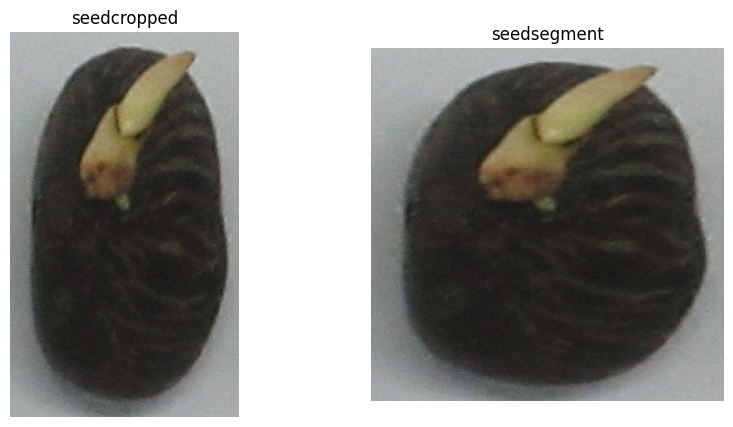



Batch 3, sample: 'badtest13.jpg'


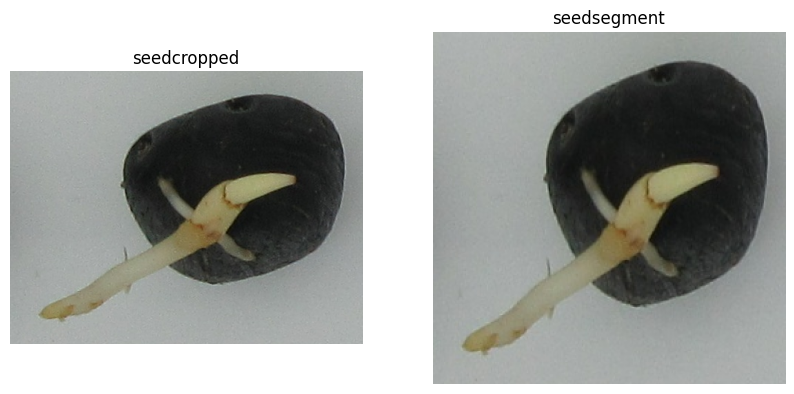

In [ ]:
def display_side_by_side(imgpath1, imgpath2):
  # Load images
  img1 = cv2.imread(imgpath1)
  img2 = cv2.imread(imgpath2)

  # Convert images from BGR to RGB (OpenCV reads images in BGR format)
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

  # Create a figure and subplots
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  # Plot images side by side
  axs[0].imshow(img1)
  axs[0].axis('off')
  axs[0].set_title('seedcropped')

  axs[1].imshow(img2)
  axs[1].axis('off')
  axs[1].set_title('seedsegment')

  # Display the plot
  plt.show()


print("Batch 2, sample: 'badtest11.jpg'")
b2imgpath1 = '/content/drive/My Drive/Datasets/Batch-2/seedcropped/test/BadSeed/badtest11.jpg'
b2imgpath2 = '/content/drive/My Drive/Datasets/Batch-2/seedsegment/test/BadSeed/badtest11.jpg'

display_side_by_side(b2imgpath1, b2imgpath2)

print("\n\nBatch 3, sample: 'badtest13.jpg'")
b3imgpath1 = '/content/drive/My Drive/Datasets/Batch-3/seedcropped/test/BadSeed/badtest13.jpg'
b3imgpath2 = '/content/drive/My Drive/Datasets/Batch-3/seedsegment/test/BadSeed/badtest13.jpg'

display_side_by_side(b3imgpath1, b3imgpath2)


# Understanding the data

In [ ]:
# Define the root directory and subdirectories
batch_dirs = ["Batch-1/seedsegment/train", "Batch-1/seedsegment/test", "Batch-2/seedsegment/test", "Batch-3/seedsegment/test"]
seed_types = ["GoodSeed", "BadSeed"]

# Iterate through each batch directory and count the images
for batch_dir in batch_dirs:
    print(f"{batch_dir}:")
    for seed_type in seed_types:
        count = 0
        for subdir, dirs, files in os.walk(os.path.join(dataset_root_dir, batch_dir)): # dataset_root_dir was defined above earlier
            if seed_type in dirs:
                count += len(os.listdir(os.path.join(subdir, seed_type)))
        print(f"  {seed_type}: {count}")
    print()

Batch-1/seedsegment/train:
  GoodSeed: 901
  BadSeed: 851

Batch-1/seedsegment/test:
  GoodSeed: 201
  BadSeed: 200

Batch-2/seedsegment/test:
  GoodSeed: 450
  BadSeed: 450

Batch-3/seedsegment/test:
  GoodSeed: 605
  BadSeed: 593



# CNN Model

## Utility functions

In [ ]:
def performance_metrics(confusion_matrix):
    TN, FP, FN, TP = confusion_matrix.ravel()

    # Calculate sensitivity (recall)
    sensitivity = TP / (TP + FN)

    # Calculate specificity
    specificity = TN / (TN + FP)

    # Calculate positive predictive value (precision)
    precision = TP / (TP + FP)

    # Calculate negative predictive value
    NPV = TN / (TN + FN)

    return sensitivity, specificity, precision, NPV

def visualize_weights(model, layer_num):
    weight_tensor = model.features[layer_num].weight.data.cpu()
    grid = vutils.make_grid(weight_tensor, nrow=4, normalize=True, scale_each=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f'Learned Weights for Layer {layer_num}')
    plt.show()

def visualize_feature_maps(model, input_image, layer_num=0):
    # Define a hook to extract the feature maps
    def hook(module, input, output):
        global feature_maps
        feature_maps = output

    # Register the hook
    handle = model.features[layer_num].register_forward_hook(hook)

    # Prepare the input image
    input_tensor = input_image.unsqueeze(0).to(device)

    # Forward pass to extract the feature maps
    _ = model(input_tensor)

    # Remove the hook
    handle.remove()

    # Visualize the feature maps
    num_feature_maps = feature_maps.size(1)
    grid_size = int(np.ceil(np.sqrt(num_feature_maps)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        if i < num_feature_maps:
            ax.imshow(feature_maps[0, i].cpu().detach().numpy(), cmap='gray')
        ax.axis('off')

    plt.suptitle(f'Feature Maps for Layer {layer_num}')
    plt.show()

def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)


def prep_output(input_img_tensor):
    # Clone the tensor to not make changes to the original
    img = input_img_tensor.clone().squeeze().detach().cpu().numpy()
    # Check if the tensor has channel dimension as the first dimension
    if img.ndim == 3:  # For color images
        # Convert from [C, H, W] to [H, W, C] for matplotlib
        img = img.transpose(1, 2, 0)
    # Normalize the image for better visualization
    img = (img - img.min()) / (img.max() - img.min())
    return img

def visualize_saliency_map(model,input_img, guided=True):

  if guided:
    handles = []
    for i, module in enumerate(model.modules()):
      if isinstance(module, torch.nn.ReLU):
          #print(model.named_modules())
          handle = module.register_backward_hook(relu_hook_function)
          handles.append(handle)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Prepare the input image
  input_img = input_img.clone().unsqueeze_(0).to(device)

  # Set requires_grad=True for the input image to compute gradients
  input_img.requires_grad = True

  # Forward pass
  model.eval()
  out = model(input_img)

  # Get the index of the maximum prediction
  pred_class = torch.argmax(out).item()
  # backprop
  out[0, pred_class].backward()
  grads = input_img.grad

  # Get the absolute values of the gradients and normalize them
  saliency, _ = torch.max(grads.data.abs(), dim=1)
  saliency = saliency.squeeze().cpu().numpy()

  if guided:
    # Remove the hooks using the handles
    for handle in handles:
        handle.remove()

  # Plot the original image and the guided saliency map
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(prep_output(input_img))
  plt.axis('off')
  plt.title('Original Image')

  plt.subplot(1, 2, 2)
  #plt.imshow(norm_flat_image(grads), cmap='hot') #works
  plt.imshow(saliency, cmap='hot')
  plt.axis('off')
  plt.title('Guided Saliency Map' if guided else 'Vanilla Saliency Map')
  plt.show()


## Load Batch 1 dataset

In [ ]:
# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load training and validation datasets
train_dataset = ImageFolder(root=r'/content/drive/MyDrive/Datasets/Batch-1/seedsegment/train', transform=data_transforms)
validation_dataset = ImageFolder(root=r'/content/drive/MyDrive/Datasets/Batch-1/seedsegment/test', transform=data_transforms)


In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=4) #numworkers speeds up dataset loading

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


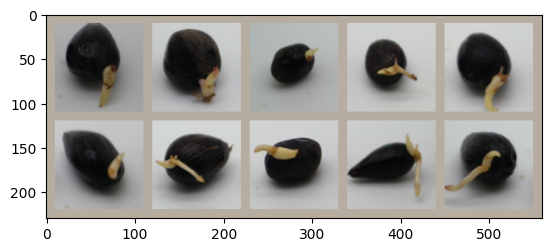

Labels: ['class1', 'class1', 'class1', 'class1', 'class1', 'class2', 'class2', 'class2', 'class2', 'class2']


In [ ]:
## Visualise
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))  # Convert to HWC format
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to the valid range [0, 1]
    plt.imshow(img)
    plt.show()


# Get indices for each class
class1_indices = [idx for idx, label in enumerate(train_dataset.targets) if label == 0]
class2_indices = [idx for idx, label in enumerate(train_dataset.targets) if label == 1]

# Randomly select some indices from each class
np.random.seed(42)  # Set the random seed for reproducibility
num_samples = 5
random_class1_indices = np.random.choice(class1_indices, num_samples, replace=False)
random_class2_indices = np.random.choice(class2_indices, num_samples, replace=False)

# Get images and labels
class1_images = [train_dataset[idx][0] for idx in random_class1_indices]
class2_images = [train_dataset[idx][0] for idx in random_class2_indices]
labels = ['class1'] * num_samples + ['class2'] * num_samples

# Create a grid of images
grid = vutils.make_grid(class1_images + class2_images, nrow=num_samples, padding=10, pad_value=1)

# Show the images
imshow(grid)
print('Labels:', labels)

## CNN model class

In [ ]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# Create the model
model = SimpleCNN()
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Train and Evaluation functions

In [ ]:
# Training function
def train_model(model, criterion, optimizer, train_loader, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
        optimizer.zero_grad()  # Clear gradients from the previous step
        outputs = model(inputs).view(-1)  # Forward pass through the model and reshape the output
        loss = criterion(outputs, labels.float())  # Calculate the loss
        loss.backward()  # Backpropagate the gradients
        optimizer.step()  # Update the model parameters

        running_loss += loss.item()  # Accumulate the running loss
        predicted = (outputs > 0.5).float()  # Apply threshold to the output to get binary predictions
        total += labels.size(0)  # Count the total number of samples
        correct += predicted.eq(labels).sum().item()  # Count the number of correct predictions

    epoch_loss = running_loss / len(train_loader)  # Calculate the average training loss
    epoch_acc = 100 * correct / total  # Calculate the training accuracy

    return epoch_loss, epoch_acc

# Validation function
def validate_model(model, criterion, validation_loader, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    # Iterate over the validation data without calculating gradients
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
            outputs = model(inputs).view(-1)  # Forward pass through the model and reshape the output
            loss = criterion(outputs, labels.float())  # Calculate the loss

            running_loss += loss.item()  # Accumulate the running loss
            predicted = (outputs > 0.5).float()  # Apply threshold to the output to get binary predictions
            total += labels.size(0)  # Count the total number of samples
            correct += predicted.eq(labels).sum().item()  # Count the number of correct predictions
            all_targets.extend(labels.cpu().numpy())  # Store the true labels for evaluation
            all_predictions.extend(predicted.cpu().numpy())  # Store the predicted labels for evaluation

    epoch_loss = running_loss / len(validation_loader)  # Calculate the average validation loss
    epoch_acc = 100 * correct / total  # Calculate the validation accuracy

    return epoch_loss, epoch_acc, all_targets, all_predictions

In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.3, inplace=False)
    (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, a

## Training and Evaluation of Batch 1 Dataset

---



In [ ]:
# Training and validation loop
num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, criterion, optimizer, train_loader, device)
    val_loss, val_acc, all_targets, all_predictions = validate_model(model, criterion, validation_loader, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/20, Train Loss: 56.0647, Train Acc: 61.3014, Val Loss: 52.8706, Val Acc: 63.5910
Epoch 2/20, Train Loss: 55.0164, Train Acc: 72.2032, Val Loss: 52.7579, Val Acc: 50.1247
Epoch 3/20, Train Loss: 54.1969, Train Acc: 78.8242, Val Loss: 53.2545, Val Acc: 84.2893
Epoch 4/20, Train Loss: 53.4495, Train Acc: 83.1050, Val Loss: 52.7585, Val Acc: 50.1247
Epoch 5/20, Train Loss: 53.2305, Train Acc: 85.0457, Val Loss: 52.6566, Val Acc: 88.0299
Epoch 6/20, Train Loss: 52.8377, Train Acc: 87.0434, Val Loss: 52.7585, Val Acc: 49.8753
Epoch 7/20, Train Loss: 52.5600, Train Acc: 88.6986, Val Loss: 52.7585, Val Acc: 49.8753
Epoch 8/20, Train Loss: 52.7991, Train Acc: 86.4726, Val Loss: 52.8212, Val Acc: 50.3741
Epoch 9/20, Train Loss: 52.5117, Train Acc: 88.7557, Val Loss: 52.5331, Val Acc: 88.2793
Epoch 10/20, Train Loss: 52.2200, Train Acc: 90.6393, Val Loss: 53.3776, Val Acc: 80.0499
Epoch 11/20, Train Loss: 52.2907, Train Acc: 90.5822, Val Loss: 52.5354, Val Acc: 91.7706
Epoch 12/20, Train 

### Evaluation Metrics for Batch 1 Dataset

Confusion Matrix:
[[188  12]
 [  0 201]]
Sensitivity: 1.00
Specificity: 0.94
Precision: 0.94
Negative Predictive Value: 1.00


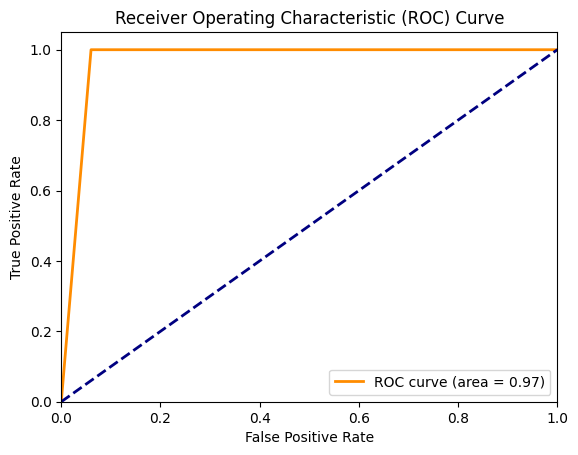

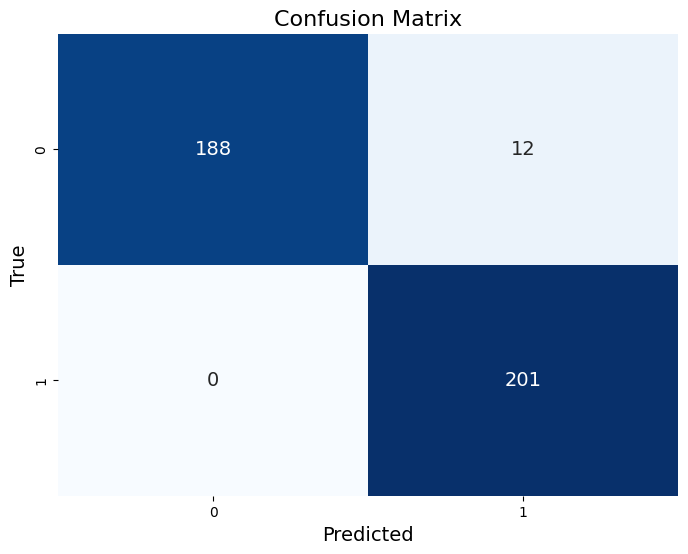

In [ ]:
# Confusion matrix
cm = metrics.confusion_matrix(all_targets, all_predictions)
print("Confusion Matrix:")
print(cm)

sensitivity, specificity, precision, NPV = performance_metrics(cm)
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Negative Predictive Value: {NPV:.2f}')

# ROC curve
fpr, tpr, _ = metrics.roc_curve(all_targets, all_predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

### Visualisation of weights

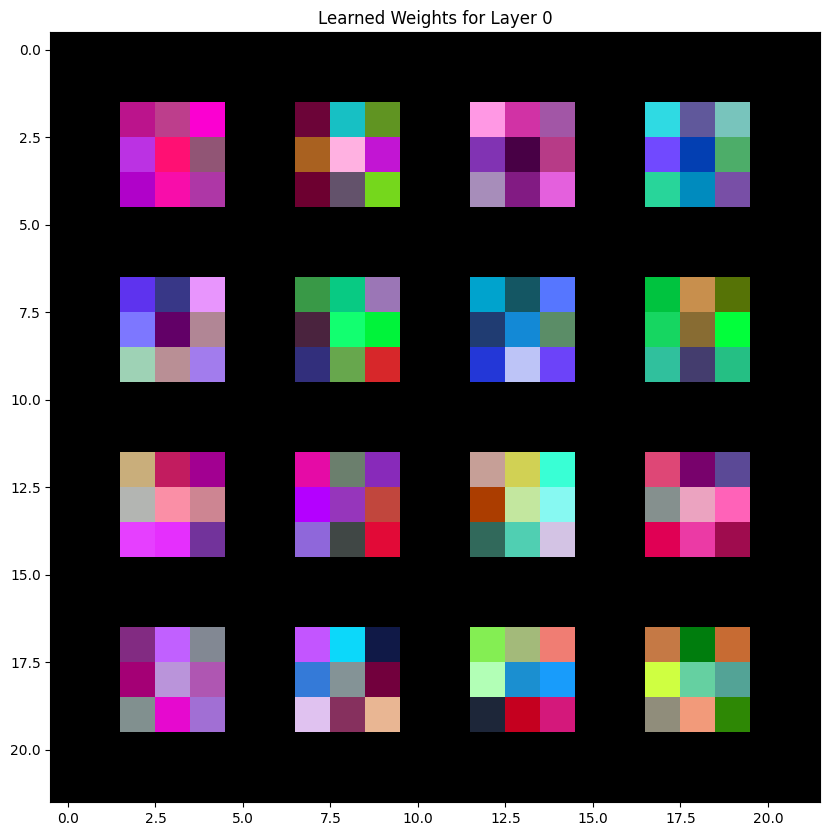

In [ ]:
visualize_weights(model, 0 ) #first layer

### Visualise feature maps for Batch 1 Dataset

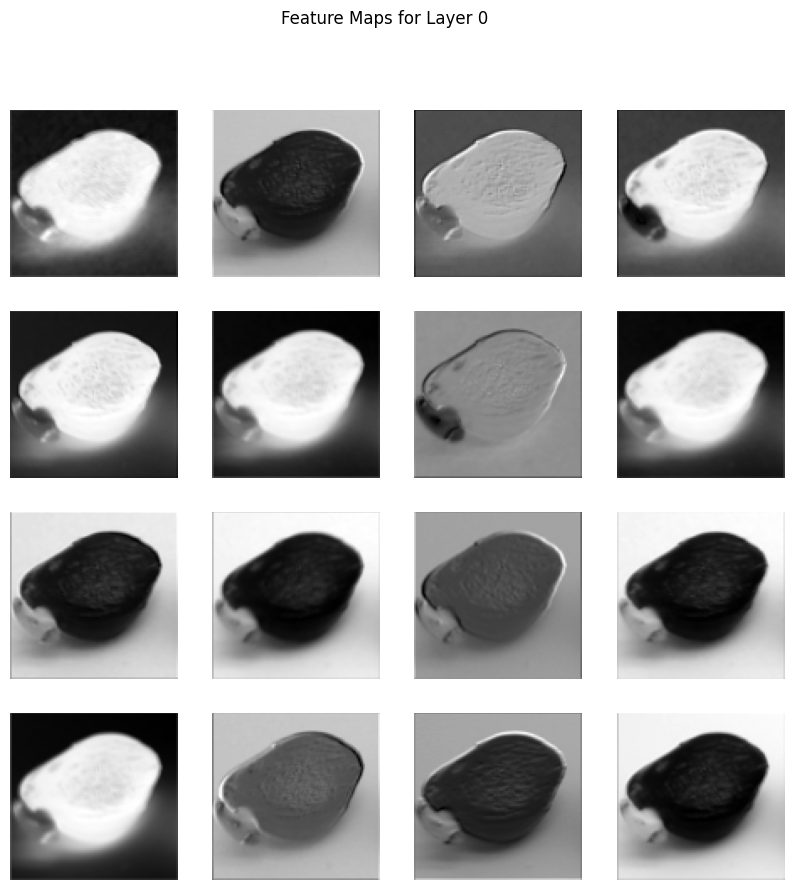

In [ ]:
# Choose an input image from the dataset
input_image, _ = train_dataset[0]

# Visualize the feature maps for the first convolutional layer
visualize_feature_maps(model, input_image, 0)

### Visualise saliency map for Batch 1 Dataset

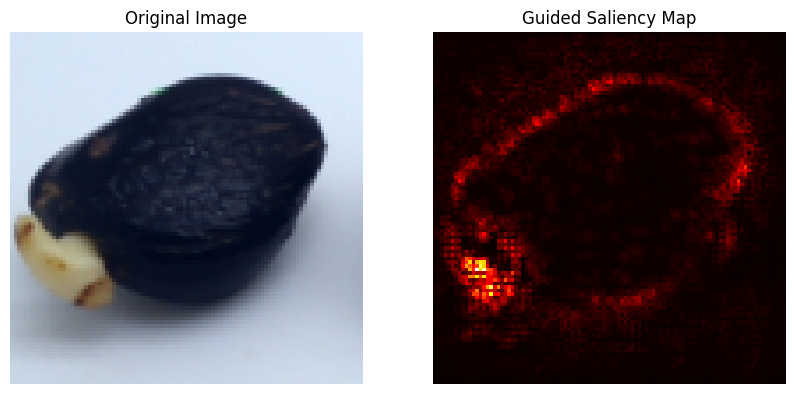

In [ ]:
visualize_saliency_map(model, input_image, guided=True)

## Evaluate Batch 2 Dataset

In [ ]:
##Eval Batch 2
# Load training and validation datasets
validation_dataset = ImageFolder(root=r'/content/drive/MyDrive/Datasets/Batch-2/seedcropped/test', transform=data_transforms)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=4) #numworkers speeds up dataset loading

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
val_loss, val_acc, all_targets, all_predictions = validate_model(model, criterion, validation_loader, device)
print(f' Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

 Val Loss: 53.5209, Val Acc: 64.6667


### Performance Metrics for Batch 2 Dataset

Confusion Matrix:
[[135 315]
 [  3 447]]
Sensitivity: 0.99
Specificity: 0.30
Precision: 0.59
Negative Predictive Value: 0.98


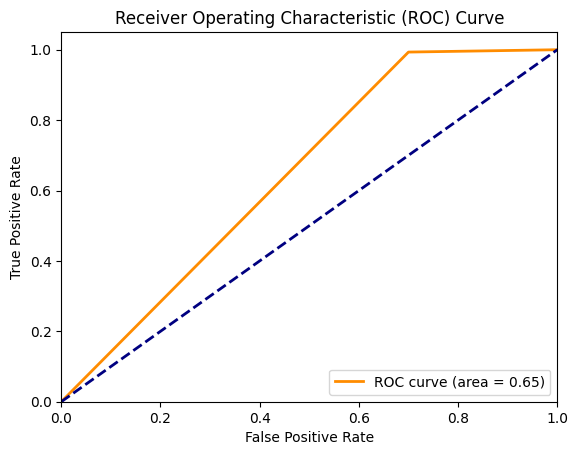

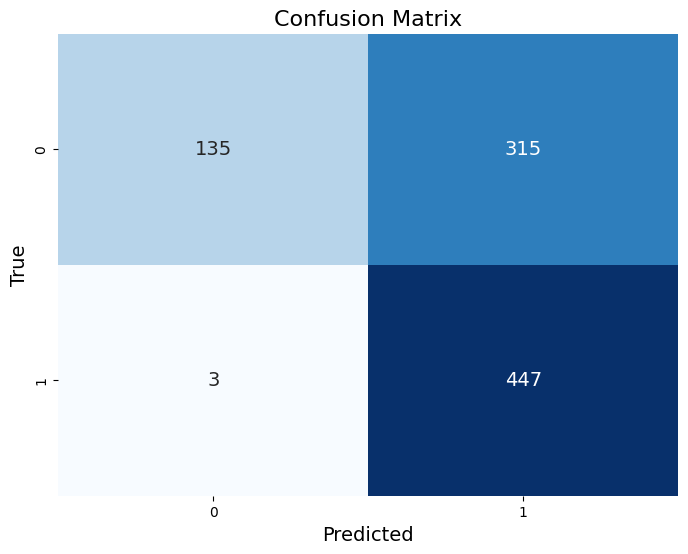

In [ ]:
# Confusion matrix
cm = metrics.confusion_matrix(all_targets, all_predictions)
print("Confusion Matrix:")
print(cm)

sensitivity, specificity, precision, NPV = performance_metrics(cm)
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Negative Predictive Value: {NPV:.2f}')

# ROC curve
fpr, tpr, _ = metrics.roc_curve(all_targets, all_predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

### Visualise feature maps for Batch 2 Dataset

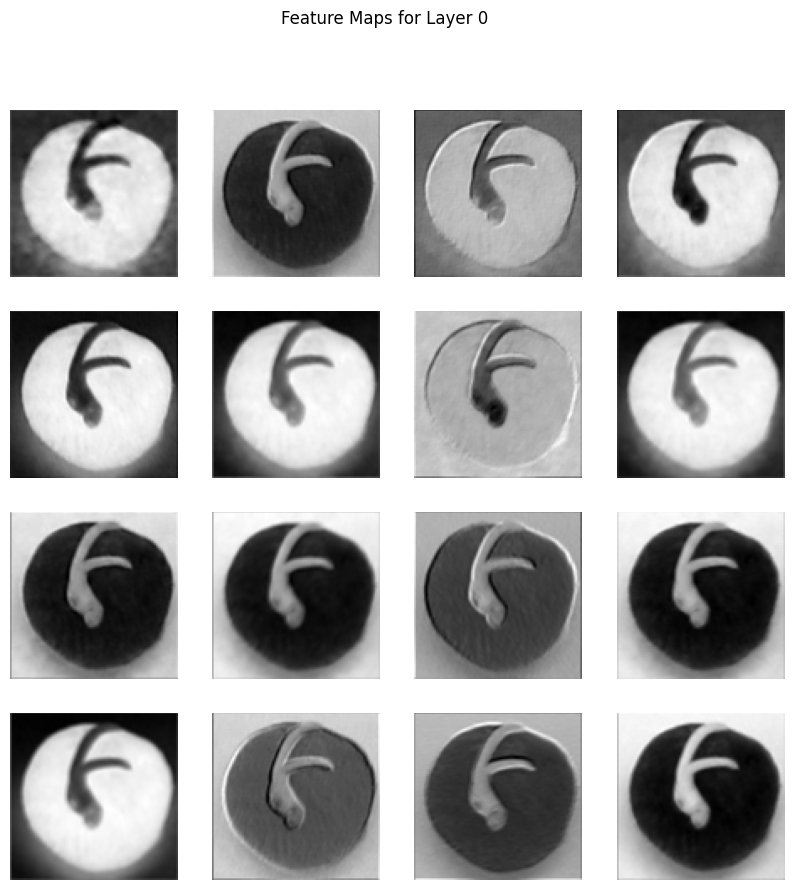

In [ ]:
# Choose an input image from the dataset
input_image, _ = validation_dataset[0]

# Visualize the feature maps for the first convolutional layer
visualize_feature_maps(model, input_image, 0)

### Visualise saliency map for Batch 2 Dataset

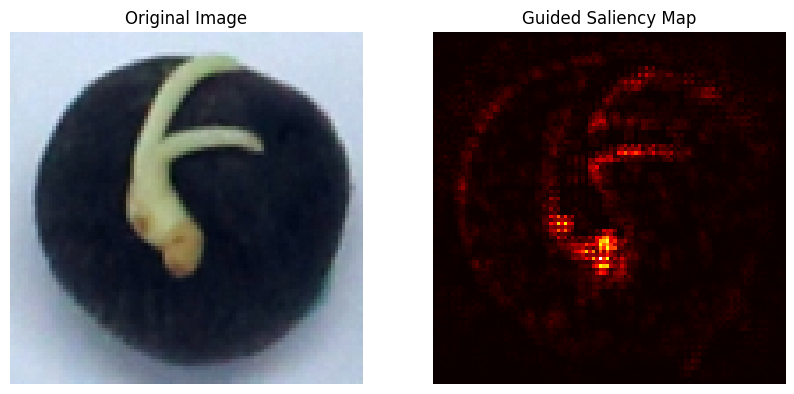

In [ ]:
visualize_saliency_map(model, input_image, guided=True)

## Evaluate Batch 3 Dataset

In [ ]:
##Eval Batch 3
# Load training and validation datasets
validation_dataset = ImageFolder(root=r'/content/drive/MyDrive/Datasets/Batch-3/seedcropped/test', transform=data_transforms)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=4) #numworkers speeds up dataset loading

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
val_loss, val_acc, all_targets, all_predictions = validate_model(model, criterion, validation_loader, device)
print(f' Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

 Val Loss: 54.9271, Val Acc: 59.6828


### Performance Metrics for Batch 3 Dataset

Confusion Matrix:
[[117 476]
 [  7 598]]
Sensitivity: 0.99
Specificity: 0.20
Precision: 0.56
Negative Predictive Value: 0.94


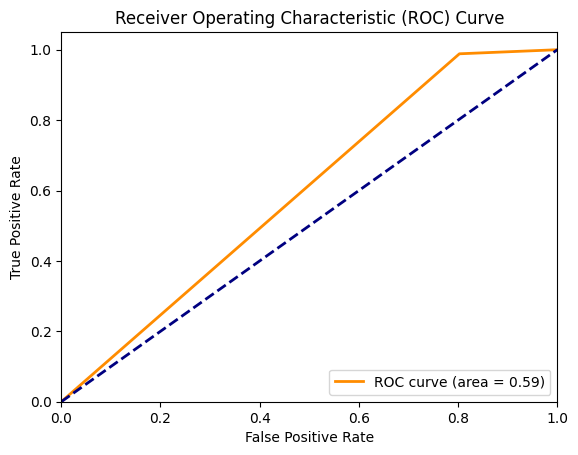

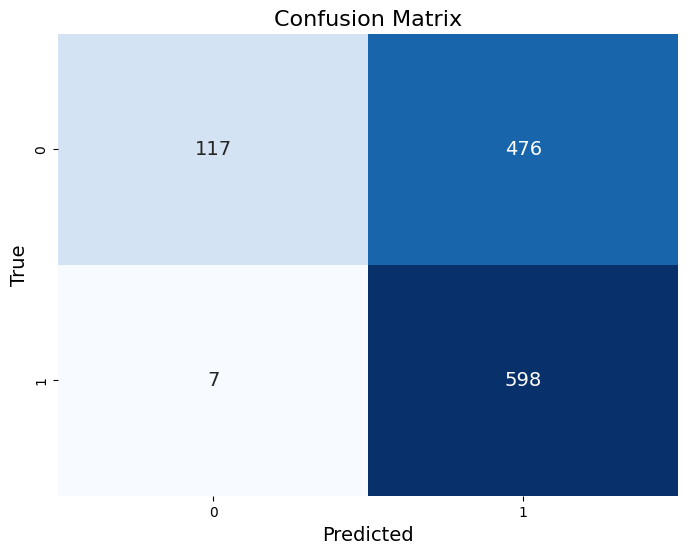

In [ ]:
# Confusion matrix
cm = metrics.confusion_matrix(all_targets, all_predictions)
print("Confusion Matrix:")
print(cm)

sensitivity, specificity, precision, NPV = performance_metrics(cm)
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Negative Predictive Value: {NPV:.2f}')

# ROC curve
fpr, tpr, _ = metrics.roc_curve(all_targets, all_predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

### Visualise feature maps for Batch 3 Dataset

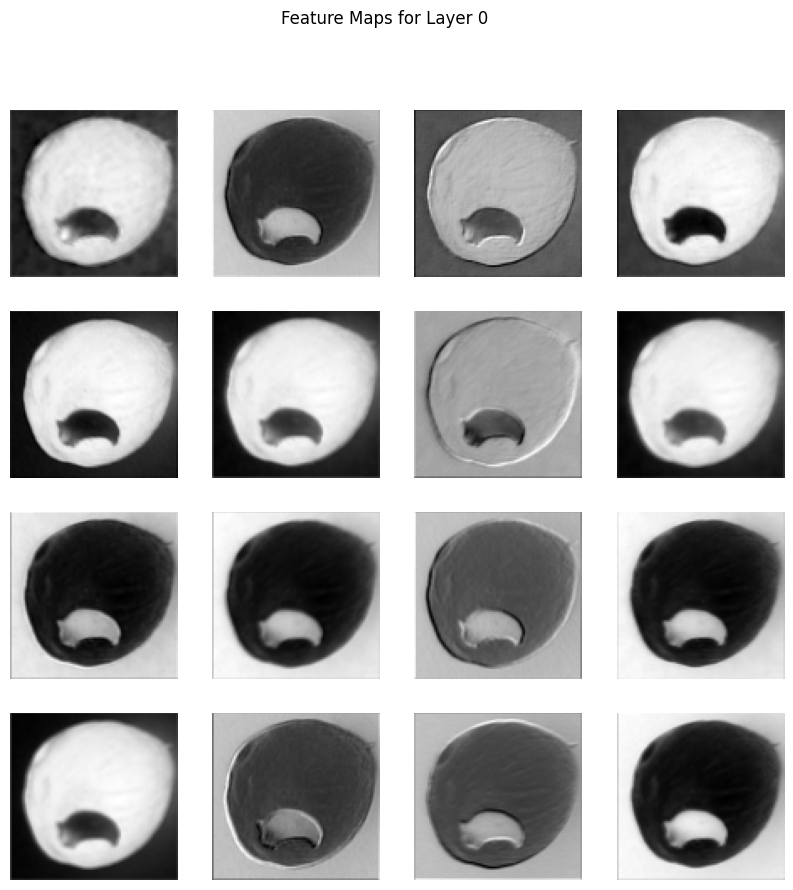

In [ ]:
# Choose an input image from the dataset
input_image, _ = validation_dataset[0]

# Visualize the feature maps for the first convolutional layer
visualize_feature_maps(model, input_image, 0)

### Visualise saliency map for Batch 3 Dataset

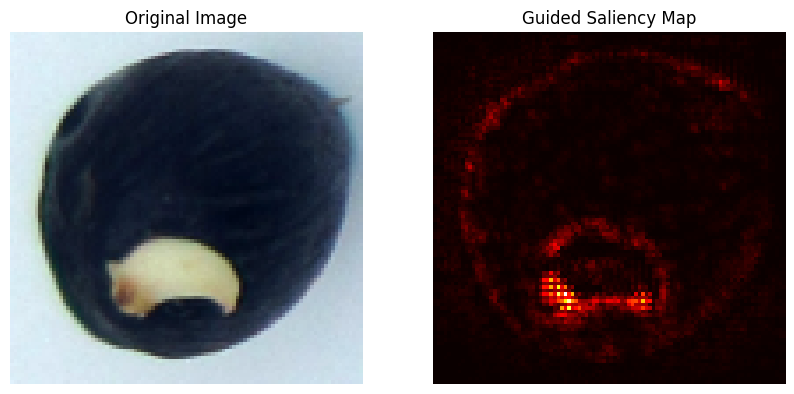

In [ ]:
visualize_saliency_map(model, input_image, guided=True)

## Transfer Learning Using Pre-Trained ResNet18 Model

**Overview**

* We will be using the ResNet18 model for this task. The model is fine-tuned for binary classification (GoodSeed or BadSeed) by replacing the last fully connected layer with a linear classifier.

* We have also built a Custom Seed Dataset class and a dataloader.

* The subsection, [Methodology](#scrollTo=WbDod6NwbezW&line=1&uniqifier=1) explains the method we followed for conducting our experiments.

* The subsection, [Experiments](#scrollTo=sKi5AHxzOpfn&line=1&uniqifier=1), shows the different experiments we conducted and the different hyperparameters we considered to determine the best model. You can read about the experiment setup [here](#scrollTo=W-NAsCXlPsWm&line=3&uniqifier=1).

* The subsection, [Results](#scrollTo=FABKyUTdg9z7&line=1&uniqifier=1) summarises our findings from the experiments.

**Note:** The best model is saved and used (loaded) for further evaluation, for task 3B of the coursework - Qualitative analysis.

## Custom Seed Dataset and Dataloader


As we extracted the B2 and B3 images in the same as B1 images, we can use a single `SeedDataset` class to load all three image batches.

### SeedDataset class

In [ ]:
# Custom dataset class inheriting from the PyTorch Dataset class
class SeedDataset(Dataset):
    def __init__(self, dataset_dir=None, train=True, transform=None):
        self.dataset_dir = dataset_dir
        self.train = train
        self.transform = transform
        self.categories = ['BadSeed', 'GoodSeed']

        self.data = []

        # Populating the data array by walking through the folders, categorically, and finding the image
        data_dir = os.path.join(self.dataset_dir, 'train' if self.train else 'test')
        for category_idx, category in enumerate(self.categories):
          category_dir = os.path.join(data_dir, category)
          for img_name in os.listdir(category_dir):
              if img_name.endswith('.png') or img_name.endswith('.jpg'):
                  self.data.append((img_name, os.path.join(category_dir, img_name), category_idx))

        #print(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

      img_name, img_path, label = self.data[idx]

      # For debugging
      #print(f"Label: {label}, Image path: {img_path}")

      # Read the image file in BGR format
      image_bgr = cv2.imread(img_path)

      # Convert the image from BGR to RGB format
      seed_img = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)


      if self.transform:
          seed_img = self.transform(seed_img)

      return img_name, seed_img, label

### Instantiate and load SeedDataset

**Note:** The base dataset directory was defined [above](#scrollTo=YT7yJbFiOYpn&line=1&uniqifier=1) when mounting the google drive.
You may change the base path there or replace `os.path.join(dataset_root_dir, 'Batch-<num>/seedsegment')` below to an absolute path to the cropped (seedsegment) images in your drive for each batch.

In [ ]:
# Defining paths to dataset directories
batch1_dataset_dir = os.path.join(dataset_root_dir, 'Batch-1/seedsegment')
batch2_dataset_dir = os.path.join(dataset_root_dir, 'Batch-2/seedsegment')
batch3_dataset_dir = os.path.join(dataset_root_dir, 'Batch-3/seedsegment')

**Note:** Mean and STD are calculated for the training dataset as shown in the [Get Mean and Standard Deviation of training dataset for Normalisation](#scrollTo=Yc9alNNu0NSU&line=1&uniqifier=1) section.

In [ ]:
# Define the image transformations
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5025, 0.5026, 0.4957], std=[0.2689, 0.2737, 0.2767])
])

In [ ]:
# Define batch size
BATCH_SIZE = 32

In [ ]:
# Get Training dataset from Batch-1
train_dataset = SeedDataset(dataset_dir=batch1_dataset_dir, train=True, transform=image_transforms)

# Split Training dataset into Training and Validation sets with a roughly 80/20 split
train_b1_dataset, validate_b1_dataset = random_split(train_dataset, [int(0.8 * len(train_dataset)), len(train_dataset) - int(0.8 * len(train_dataset))])

# Load Training and Validation datesets.
train_b1_dataloader = DataLoader(dataset=train_b1_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validate_b1_dataloader = DataLoader(dataset=validate_b1_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Get and load Testing dataset from Batch-1,2,3
test_b1_dataset = SeedDataset(dataset_dir=batch1_dataset_dir, train=False, transform=image_transforms)
test_b1_dataloader = DataLoader(dataset=test_b1_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_b2_dataset = SeedDataset(dataset_dir=batch2_dataset_dir, train=False, transform=image_transforms)
test_b2_dataloader = DataLoader(dataset=test_b2_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_b3_dataset = SeedDataset(dataset_dir=batch3_dataset_dir, train=False, transform=image_transforms)
test_b3_dataloader = DataLoader(dataset=test_b3_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


### Get Mean and Standard Deviation of training dataset for Normalisation

You may choose to skip running this section.

**Note:** Before loading the data and calculating the mean and std, make sure to comment this line: `transforms.Normalize(mean=[0.5025, 0.5026, 0.4957], std=[0.2689, 0.2737, 0.2767])` from [image_transforms](#scrollTo=pNB1CdAbME_-&line=1&uniqifier=1) defined above. Otherwise, by running the function we will get the already normalised mean and std.


In [ ]:
def get_mean_and_std(train_loader):
  mean = 0.
  std = 0.
  total_images_count = 0
  for _, images, _ in train_loader:

    # Get number of images in a batch, rolling count
    image_count_in_a_batch = images.size(0)

    # Reshape the image tensor
    #print(images.shape)
    images = images.view(image_count_in_a_batch, images.size(1), -1) # reshaping tensors from torch.Size([32, 3, 256, 256]) to torch.Size([32, 3, 65536])
    #print(images.shape)

    # Calculate the mean and std batchwise
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += image_count_in_a_batch

  # Get mean and std for entire training dataset
  mean /= total_images_count
  std /= total_images_count

  print(f"Mean: {mean}")
  print(f"Standard deviation: {std}")

  return mean, std


It is expected to get slightly different values for mean and std each time you call get_mean_and_std() function when the calculation is done batch-wise and the samples included in each batch are randomly selected. Therefore, the statistical properties of each batch can vary slightly each time the function is called.

As long as the differences in mean and std values between multiple runs are not significant, it is okay to use the approximated values obtained from one run for image normalization transforms. However, to get more accurate values we can increase the batch size of the data loader or use the entire dataset to calculate mean and std.

In [ ]:
# Mean & STD before normalisation
mean, std = get_mean_and_std(train_b1_dataloader)

Mean: tensor([0.0065, 0.0059, 0.0056])
Standard deviation: tensor([0.9996, 1.0000, 1.0002])


**Note:** Now we will use the values obtained for [mean and std](#scrollTo=uTHx9jwt7zkU&line=1&uniqifier=1) for normalisation. You may now uncomment the previously commented line:  `transforms.Normalize(mean=mean, std=std)` and run the [image_transforms](#scrollTo=pNB1CdAbME_-&line=1&uniqifier=1) and [loader](#scrollTo=u0xTCzlXg61I&line=1&uniqifier=1) cells again.

Sanity check: after normalization the mean and std seem to be within the expected range of [0, 1].

In [ ]:
# Mean & STD after normalisation
mean, std = get_mean_and_std(train_b1_dataloader)

Mean: tensor([0.0065, 0.0059, 0.0056])
Standard deviation: tensor([0.9996, 1.0000, 1.0002])


## Testing dataset and dataloader

This section is just for testing purposes. You may choose to skip running it.

In [ ]:
# Checking the dataset length and a sample of data
print(f"B1 Train Dataset length: {len(train_b1_dataset)}")
print(f"B1 Train Data sample: {train_dataset.data[train_b1_dataset.indices[0]]}\n") # Access the first training sample from the original train_dataset using the index of first training sub-sample

print(f"B1 Validation Dataset length: {len(validate_b1_dataset)}")
print(f"B1 Validation Data sample: {train_dataset.data[validate_b1_dataset.indices[0]]}\n") # Access the first validation sample from the original train_dataset using the index of first validation sub-sample

print(f"B1 Test Dataset length: {len(test_b1_dataset.data)}")
print(f"B1 Test Data sample: {test_b1_dataset.data[0]}\n")

print(f"B2 Test Dataset length: {len(test_b2_dataset.data)}")
print(f"B2 Test Data sample: {test_b2_dataset.data[0]}\n")

print(f"B3 Test Dataset length: {len(test_b3_dataset.data)}")
print(f"B3 Test Data sample: {test_b3_dataset.data[0]}\n")

B1 Train Dataset length: 1401
B1 Train Data sample: ('goodtrain470.png', '/content/drive/My Drive/Datasets/Batch-1/seedsegment/train/GoodSeed/goodtrain470.png', 1)

B1 Validation Dataset length: 351
B1 Validation Data sample: ('badtrain350.png', '/content/drive/My Drive/Datasets/Batch-1/seedsegment/train/BadSeed/badtrain350.png', 0)

B1 Test Dataset length: 401
B1 Test Data sample: ('badtest2.png', '/content/drive/My Drive/Datasets/Batch-1/seedsegment/test/BadSeed/badtest2.png', 0)

B2 Test Dataset length: 900
B2 Test Data sample: ('badtest10.jpg', '/content/drive/My Drive/Datasets/Batch-2/seedsegment/test/BadSeed/badtest10.jpg', 0)

B3 Test Dataset length: 1198
B3 Test Data sample: ('badtest10.jpg', '/content/drive/My Drive/Datasets/Batch-3/seedsegment/test/BadSeed/badtest10.jpg', 0)



In [ ]:
# Get a batch of data from the data loader
b1_train_img_names, b1_train_images, b1_train_labels = next(iter(train_b1_dataloader))
b1_validate_img_names, b1_validate_images, b1_validate_labels = next(iter(validate_b1_dataloader))
b1_test_img_names, b1_test_images, b1_test_labels = next(iter(test_b1_dataloader))
b2_test_img_names, b2_test_images, b2_test_labels = next(iter(test_b2_dataloader))
b3_test_img_names, b3_test_images, b3_test_labels = next(iter(test_b3_dataloader))

### Visualise batches

B1 Train image batch shape: torch.Size([32, 3, 256, 256])
B1 Train labels batch shape: torch.Size([32])
B1 Train labels: tensor([1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1])


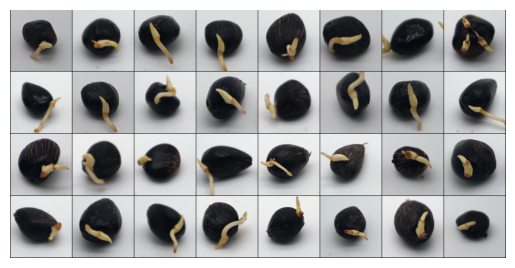

In [ ]:
# Train batch
print(f"B1 Train image batch shape: {b1_train_images.size()}")
print(f"B1 Train labels batch shape: {b1_train_labels.size()}")
print(f"B1 Train labels: {b1_train_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b1_train_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B1 Validate image batch shape: torch.Size([32, 3, 256, 256])
B1 Validate labels batch shape: torch.Size([32])
B1 Validate labels: tensor([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0])


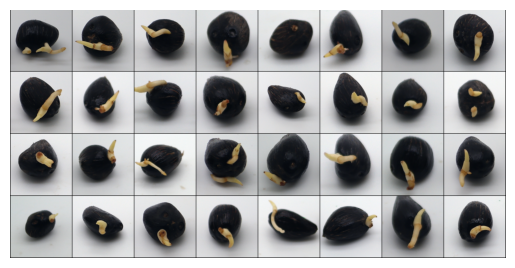

In [ ]:
# Validation batch
print(f"B1 Validate image batch shape: {b1_validate_images.size()}")
print(f"B1 Validate labels batch shape: {b1_validate_labels.size()}")
print(f"B1 Validate labels: {b1_validate_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b1_validate_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B1 Test image batch shape: torch.Size([32, 3, 256, 256])
B1 Test labels batch shape: torch.Size([32])
B1 Test Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1])


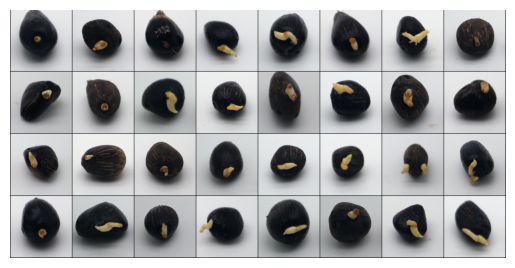

In [ ]:
# Test B1
print(f"B1 Test image batch shape: {b1_test_images.size()}")
print(f"B1 Test labels batch shape: {b1_test_labels.size()}")
print(f"B1 Test Labels: {b1_test_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b1_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B2 Test image batch shape: torch.Size([32, 3, 256, 256])
B2 Test labels batch shape: torch.Size([32])
B2 Test Labels: tensor([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1])


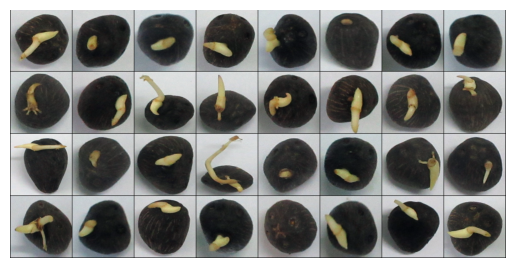

In [ ]:
# Test B2
print(f"B2 Test image batch shape: {b2_test_images.size()}")
print(f"B2 Test labels batch shape: {b2_test_labels.size()}")
print(f"B2 Test Labels: {b2_test_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b2_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B3 Test image batch shape: torch.Size([32, 3, 256, 256])
B3 Test labels batch shape: torch.Size([32])
B3 Test Labels: tensor([1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1])


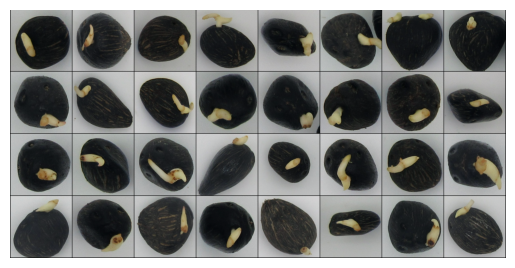

In [ ]:
# Test B3
print(f"B3 Test image batch shape: {b3_test_images.size()}")
print(f"B3 Test labels batch shape: {b3_test_labels.size()}")
print(f"B3 Test Labels: {b3_test_labels}")
# Create a grid of images from the batch to see the individual seed sample
grid = vutils.make_grid(b3_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

## Utility functions

These functions set the foundation to run our experiments, evaluate the performance of our models, logging key metrics and saving the best model.

### train_model()

In [ ]:
# Train and validate the model and log data to wandb
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    model = model.to(device)
    wandb.watch(model, criterion, log='all', log_freq=100)

    for epoch in tqdm(range(num_epochs), desc=f"Training and validation in progress: "):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the training dataset
        for batch_idx, (_, inputs, labels) in enumerate(train_loader):  # (see above) SeedDataset.__getitem__ returns: img_name, seed_img, label

            # Uncomment this to see which batch the model is training
            # print(f"Processing batch {batch_idx+1}/{len(train_loader)}")

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate batch-wise loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate epoch-wise loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Log training results to wandb
        wandb.log({"epoch": epoch+1, "b1_train_loss": epoch_loss, "b1_train_accuracy": epoch_acc})

        # Print training statistics
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

        # Evaluate on the validation dataset (for validation, set the test flag to false)
        val_loss, val_acc, true_labels, predicted_labels, predicted_probs = evaluate_model("b1", model, criterion, val_loader, test=False)

    return model, optimizer, val_loss, val_acc, true_labels, predicted_labels, predicted_probs

### evaluate_model()

In [ ]:
# Evaluate the model on the validation and test sets
# The function can evaluate the model on the validation or test dataset based on the test flag.
def evaluate_model(batch_num, model, criterion, eval_loader, test=True, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):

    eval_mode = "test" if test else "val"
    model.eval()

    running_loss = 0.0
    running_corrects = 0

    # To compute metrics initialize empty lists to store true labels, predicted labels and predicted probabilities
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    with torch.no_grad():
        for _, inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Calculate batch-wise loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Store true labels and predictions for the current batch to compute performance metrics (precision, recall, F1-score, AUC, etc)
            true_labels.extend(labels.cpu().numpy()) # The tensor need to be in the CPU memory to complete this operation
            predicted_labels.extend(preds.cpu().numpy())

            # Store true labels and predicted probabilities for the current batch
            predicted_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[:, 1])  # Class 1 is the positive class (GoodSeed)

        # Calculate epoch-wise loss and accuracy
        epoch_loss = running_loss / len(eval_loader.dataset)
        epoch_acc = running_corrects.double() / len(eval_loader.dataset)

        # Log evaluation results to wandb
        wandb.log({
            f"{batch_num}_{eval_mode}_loss": epoch_loss,
            f"{batch_num}_{eval_mode}_accuracy": epoch_acc,
        })

        # Print test statistics
        eval_mode = "Test" if test else "Val"
        print(f"{eval_mode} Loss: {epoch_loss:.4f}, {eval_mode} Accuracy: {epoch_acc:.4f}")

    return epoch_loss, epoch_acc, true_labels, predicted_labels, predicted_probs

### compute_performance_metrics()

In [ ]:
# Calculates the conf_matrix, precision, npv, sensitivity, specificity, f1_score, auc, fpr, tpr
def compute_performance_metrics(figure_name, true_labels, predicted_labels, predicted_probs):
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    predicted_probs = np.array(predicted_probs)

    # Compute confusion matrix
    conf_matrix = metrics.confusion_matrix(true_labels, predicted_labels)

    # Get True/False Positive/Negative values
    tn, fp, fn, tp = conf_matrix.ravel()

    # Compute Postive Predictive Value (precision), Negative Predictive Value (NPV), sensitivity (recall), specificity, and F1-score
    precision = tp / (tp + fp)
    npv = tn / (tn + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    # Compute AUC
    fpr, tpr, thresholds = metrics.roc_curve(true_labels, predicted_probs)
    auc = metrics.auc(fpr, tpr)

    print(f"{figure_name}   Precision: {precision:.4f}, NPV: {npv:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, F1-score: {f1_score:.4f}, AUC: {auc:.4f}")

    return conf_matrix, precision, npv, sensitivity, specificity, f1_score, auc, fpr, tpr

### plot_confusion_matrices()

In [ ]:
# Plots the confusion matrices of each evaluation set in a row, side by side.
def plot_confusion_matrices(val_conf_matrix, b1_conf_matrix, b2_conf_matrix, b3_conf_matrix):

    print() #line for spacing

    # Create the figure with 4 subplots
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

    # Set the title of each subplot
    titles = ['Validation', 'Test B1', 'Test B2', 'Test B3']

    # Loop through each subplot and plot the corresponding confusion matrix
    for i, ax in enumerate(axs.flatten()):
        if i == 0:
            conf_matrix = val_conf_matrix
        elif i == 1:
            conf_matrix = b1_conf_matrix
        elif i == 2:
            conf_matrix = b2_conf_matrix
        else:
            conf_matrix = b3_conf_matrix
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"fontsize": 14}, ax=ax)
        ax.set_title(titles[i])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    # Set the title for the entire figure
    fig.suptitle("Confusion Matrices")
    plt.tight_layout()
    plt.show()

### plot_roc_curve()

In [ ]:
# Plots the roc curve for each evaluation set
def plot_roc_curve(figure_name, auc, fpr, tpr):
    print() #line for spacing
    # Visualize the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{figure_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

### save_best_model()

In [ ]:
# Saves the best performing model in terms of accuracy (saves 4 models, one for each evaluation set e.g. best_val_model, best_b1_test_model etc)
def save_best_model(model_code, exp_name, trained_model, trained_optimizer, current_acc, best_acc, metric_name, storage_path):
    # Save the model only if the current test accuracy is better than the previously stored model's test accuracy
    if current_acc > best_acc:
        print(f"{metric_name} improved from {best_acc:.4f} to {current_acc:.4f}. Saving model...\n")
        best_acc = current_acc

        # Saving both the model and optimizer state together (for future improvement: also store `best_accuracies` dict state here)
        state = {
            'experiment_name': exp_name,
            'model_state_dict': trained_model.state_dict(),
            'optimizer_state_dict': trained_optimizer.state_dict()
        }
        file_name = f"{storage_path}/{model_code}_best_{metric_name}_model.pt"
        torch.save(state, file_name)

        # Create wandb artifact to save the model with a wandb run
        artifact = wandb.Artifact(f"{model_code}_best_{metric_name}_model.pt", type='model')

        # Add the saved model file to the artifact
        artifact.add_file(file_name)

        # Log the artifact to Wandb
        wandb.log_artifact(artifact)

    return best_acc

### freeze_layers()

In [ ]:
# Freezes the pretrained layers when performing transfer learning
def freeze_layers(model, freeze=True, last_layer_name="fc"):
    if freeze:
        # Freeze all layers except the last one
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze the last layer
        last_layer = getattr(model, last_layer_name)
        for param in last_layer.parameters():
            param.requires_grad = True
    return model

### run_experiment()


**Experiment Setup**

* As we are classifying seeds into two categories (BadSeed or GoodSeed), we used Cross-entropy loss as the loss function, [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss). Note: Since we are dealing with a binary classification problem, we could have also used Binary Cross-Entropy loss function,[`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss). In this case, we would have had to add a sigmoid activation layer after the final linear classifier layer of the [model](#scrollTo=42RKaCaXnKX_), as well as set thresholds in the training and evaluation loops. Better yet, use [torch.nn.BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#bcewithlogitsloss), which like `torch.nn.CrossEntropyLoss` can take raw logits from a linear classifier as inputs directly, skipping the need to add the last sigmoid layer as in the case of `torch.nn.BCELoss`. (But we only realised this later on)

* For each experiment, the number of epochs and type of optimizer and its arguements (learning rate, momentum, alpha, beta) are set as hyperparameters, which we will change to find the best performance.

* Additional flags are also set to accept either SimpleCNN or the Pretrained model, these include `freeze` and `transfer_learning`.

* We used the Weights & Biases (wandb) library to monitor the model's training progress, and log the hyperparameters, loss and accuracy for the training, validation and test sets for each experiment.

* Lastly, across the experiments conducted, we are keeping track of 4 models based on the accuracy using `best_accuracies`. Each time any of the accuracy of any of the evaluation sets (Validation, Test B1, Test B2, Test B3) improves, the respective model will be saved. One of this saved model is then loaded for further qualitative analysis.

In [ ]:
# Run experiments with different hyperparameter values (Hyperparameters => optimizer, epochs) and saves logs to wandb
def run_experiment(best_accuracies, exp_name, model, optimizer_type, optimizer_args, epochs, freeze=False, transfer_learning=True):

    if transfer_learning:
      model_code = 'TL_CNN'
    else:
      model_code = 'Simple_CNN'

    # Keeping track of the model with the best accuracy across different experiments
    best_val_acc = best_accuracies['val_acc']
    best_b1_test_acc = best_accuracies['b1_test_acc']
    best_b2_test_acc = best_accuracies['b2_test_acc']
    best_b3_test_acc = best_accuracies['b3_test_acc']

    # For transfer learning with Resnet18 model - Freeze the pre-trained layers if freeze flag is true (not freezing aka updating the weights of the pre-trained layers is computationally expensive)
    if freeze:
      freeze_layers(model)
      print("Froze all layers of the model except the last layer\n")

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Create the optimizer with the given type and arguments for current experiment
    optimizer = optimizer_type(model.parameters(), **optimizer_args)

    config = {
        'optimizer': optimizer.__class__.__name__, # retrieves the name of the optimizer's class (e.g., 'SGD', 'Adagrad') by accessing the optimizer's class attribute __name__.
        'learning_rate': optimizer.param_groups[0]['lr'], # retrieves the learning rate of the first (and typically only) parameter group by accessing the lr key in the dictionary.
        'momentum': optimizer.param_groups[0].get('momentum', None), # attempts to retrieve the momentum of the first parameter group by accessing the momentum key in the dictionary. If the momentum key is not found (e.g., for optimizers that don't use momentum), the get() method will return None.
        'alpha': optimizer.param_groups[0].get('alpha', None),
        'betas': optimizer.param_groups[0].get('betas', None),
        'num_epochs': epochs,
        'freeze': freeze,
    }

    with wandb.init(project='seed-classification', config=config, group=exp_name, name=f'{exp_name}_optimizer_{config["optimizer"]}_epochs_{epochs}_freeze_{freeze}'):

        # Train the model with B1 data
        print("\nTRAIN AND VALIDATE")
        trained_model, trained_optimizer, val_loss, val_acc, val_true_labels, val_predicted_labels, val_predicted_probs = train_model(
            model, criterion, optimizer, train_b1_dataloader, validate_b1_dataloader, num_epochs=epochs)

        # Test the model with B1, B2, and B3 data
        print("\nTEST BATCH-1")
        b1_test_loss, b1_test_acc, b1_true_labels, b1_predicted_labels, b1_predicted_probs = evaluate_model(
            "b1", model, criterion, test_b1_dataloader, test=True)

        print("\nTEST BATCH-2")
        b2_test_loss, b2_test_acc, b2_true_labels, b2_predicted_labels, b2_predicted_probs = evaluate_model(
            "b2", model, criterion, test_b2_dataloader, test=True)

        print("\nTEST BATCH-3")
        b3_test_loss, b3_test_acc, b3_true_labels, b3_predicted_labels, b3_predicted_probs = evaluate_model(
            "b3", model, criterion, test_b3_dataloader, test=True)


        # Compute confusion matrix, precision, recall, f1-score, auc, roc curve for all evaluation sets
        print("\nPERFORMANCE METRICS")
        val_conf_matrix, val_precision, val_npv, val_sensitivity, val_specificity, val_f1_score, val_auc, val_fpr, val_tpr = compute_performance_metrics(
            "Validation", val_true_labels, val_predicted_labels, val_predicted_probs)

        b1_conf_matrix, b1_precision, b1_npv, b1_sensitivity, b1_specificity, b1_f1_score, b1_auc, b1_fpr, b1_tpr = compute_performance_metrics(
            "Test B1", b1_true_labels, b1_predicted_labels, b1_predicted_probs)

        b2_conf_matrix, b2_precision, b2_npv, b2_sensitivity, b2_specificity, b2_f1_score, b2_auc, b2_fpr, b2_tpr = compute_performance_metrics(
            "Test B2", b2_true_labels, b2_predicted_labels, b2_predicted_probs)

        b3_conf_matrix, b3_precision, b3_npv, b3_sensitivity, b3_specificity, b3_f1_score, b3_auc, b3_fpr, b3_tpr = compute_performance_metrics(
            "Test B3", b3_true_labels, b3_predicted_labels, b3_predicted_probs)

        plot_confusion_matrices(val_conf_matrix, b1_conf_matrix, b2_conf_matrix, b3_conf_matrix)

        plot_roc_curve("Validation", val_auc, val_fpr, val_tpr)
        plot_roc_curve("Test B1", b1_auc, b1_fpr, b1_tpr)
        plot_roc_curve("Test B2", b2_auc, b2_fpr, b2_tpr)
        plot_roc_curve("Test B3", b3_auc, b3_fpr, b3_tpr)

        print() # new line
        storage_path = "/content/drive/MyDrive/Datasets/Best-Models"

        # Save the model based on the best (val, b1_test, b2_test, b3_test) accuracy - keeping track of all 4 accuracies
        best_val_acc = save_best_model(model_code, exp_name, trained_model, trained_optimizer, val_acc, best_val_acc, "val_acc", storage_path)
        best_b1_test_acc = save_best_model(model_code, exp_name, trained_model, trained_optimizer, b1_test_acc, best_b1_test_acc, "b1_test_acc", storage_path)
        best_b2_test_acc = save_best_model(model_code, exp_name, trained_model, trained_optimizer, b2_test_acc, best_b2_test_acc, "b2_test_acc", storage_path)
        best_b3_test_acc = save_best_model(model_code, exp_name, trained_model, trained_optimizer, b3_test_acc, best_b3_test_acc, "b3_test_acc", storage_path)

    # Update global best accuracies
    best_accuracies = {
    "val_acc": best_val_acc,
    "b1_test_acc": best_b1_test_acc,
    "b2_test_acc": best_b2_test_acc,
    "b3_test_acc": best_b3_test_acc,
    }
    return best_accuracies

### prep_input()

We will apply the same [`image_transforms`](#scrollTo=pNB1CdAbME_-&line=4&uniqifier=1) which we used to prepare the datasets for training and testing, defined above.

In [ ]:
def prep_input(image_path):
  # Read the image file in BGR format and convert it from BGR to RGB format
  image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  # Preprocess image - using the same image transforms that were used when loading the datasets.
  preprocessed_image = image_transforms(image)

  return preprocessed_image

### prep_output()

In [ ]:
def prep_output(img_tensor):
    # Reverse normalisation to see original image - inverse matrix multiplication
    invTrans = transforms.Compose([
      transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.2689, 1/0.2737, 1/0.2767 ]),
      transforms.Normalize(mean = [ -0.5025, -0.5026, -0.4957 ], std = [ 1., 1., 1. ]),
    ])
    out = invTrans(img_tensor)[0]
    out = out.cpu().detach().numpy().transpose(1, 2, 0)
    return out

### visualize_learned_weights()

In [ ]:
def plot_filters_single_channel_big(t):

    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]

    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)

    npimg = npimg.T

    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

In [ ]:
def plot_filters_single_channel(t):

    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12

    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)

    count = 0
    fig = plt.figure(figsize=(ncols, nrows))

    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_filters_multi_channel(t):

    #get the number of kernals
    num_kernels = t.shape[0]

    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels

    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))

    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)

        #for each kernel, we convert the tensor to numpy
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.tight_layout()
    plt.show()

In [ ]:
def get_layer_by_name(model, layer_name):
    for name, layer in model.named_modules():
        if name == layer_name:
            return layer
    raise ValueError(f"Layer not found: {layer_name}")

In [ ]:
def visualize_learned_weights(model, layer_name, layer_type, single_channel=True, collated=False):

    print(f"Learned Weights for layer: {layer_type}\n")

    layer = get_layer_by_name(model, layer_name)

    # checking whether the layer is convolution layer or not
    if isinstance(layer, nn.Conv2d):
        # getting the weight tensor data
        weight_tensor = layer.weight.data

        print(f"Weight tensor shape: {weight_tensor.shape}\n")

        # Move the weight tensor to CPU
        weight_tensor = weight_tensor.cpu()

        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")

    else:
        print("Can only visualize layers which are convolutional")

### visualize_feature_maps()

In [ ]:
def get_layer(model, layer_path):
    layers = layer_path.split(".")
    current_layer = model
    for layer in layers:
        current_layer = getattr(current_layer, layer)
    return current_layer

In [ ]:
def visualize_feature_maps(model, input_tensor, layer_path='0'):
    # Define a hook to extract the feature maps
    def hook(module, input, output):
        global feature_maps
        feature_maps = output

    # Access the specified layer
    layer = get_layer(model, layer_path)

    # Register the hook
    handle = layer.register_forward_hook(hook)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Prepare the input image
    input_tensor = input_tensor.clone().unsqueeze_(0).to(device) # .clone() because I don't want to modify the original image dimensions

    # Forward pass to extract the feature maps
    _ = model(input_tensor)

    # Remove the hook
    handle.remove()

    # Visualize the feature maps
    num_feature_maps = feature_maps.size(1)
    grid_size = int(np.ceil(np.sqrt(num_feature_maps)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        if i < num_feature_maps:
            ax.imshow(feature_maps[0, i].cpu().detach().numpy(), cmap='gray')
        ax.axis('off')

    plt.suptitle(f'Feature Maps for Layer: {layer_path}')
    plt.show()

### visualize_saliency_map()

In [ ]:
def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)

In [ ]:
def visualize_saliency_map(model,input_img, guided=True):

  if guided:
    handles = []
    for i, module in enumerate(model.modules()):
      if isinstance(module, torch.nn.ReLU):
          #print(model.named_modules())
          handle = module.register_backward_hook(relu_hook_function)
          handles.append(handle)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Prepare the input image
  input_img = input_img.clone().unsqueeze_(0).to(device)

  # Set requires_grad=True for the input image to compute gradients
  input_img.requires_grad = True

  # Forward pass
  model.eval()
  out = model(input_img)

  # Get the index of the maximum prediction
  pred_class = torch.argmax(out).item()
  # backprop
  out[0, pred_class].backward()
  grads = input_img.grad

  # Get the absolute values of the gradients and normalize them
  saliency, _ = torch.max(grads.data.abs(), dim=1)
  saliency = saliency.squeeze().cpu().numpy()

  if guided:
    # Remove the hooks using the handles
    for handle in handles:
        handle.remove()

  # Plot the original image and the guided saliency map
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(prep_output(input_img))
  plt.axis('off')
  plt.title('Original Image')

  plt.subplot(1, 2, 2)
  #plt.imshow(norm_flat_image(grads), cmap='hot') #works
  plt.imshow(saliency, cmap='hot')
  plt.axis('off')
  plt.title('Guided Saliency Map' if guided else 'Vanilla Saliency Map')
  plt.show()

## Methodology

We conducted 3 experiments using different hyperparameters and each experiment was run twice.

The number of epochs was set to `10` for all runs, for better comparison of the different optimisation algorithms used.

Optimisation algorithms used are Exp-1: `SGD with Momentum`, Exp-2: `RMSprop`, Exp-3: `Adam`.

For each experiment, in Run 1 the pre-trained layers were frozen by setting the freeze flag to `True`, hence the parameters/weights for these layers were not being updated.

In Run 2, however, we set freeze to `False` to update the weights of the pre-trained layers. By not freezing the layers, the model is able to learn task-specific features by updating the weights of the entire network during training. The model can adapt better to the new dataset, capturing more complex patterns and nuances that may not have been present in the original dataset. This can lead to better performance. Albeit, this comes at a computational cost.



## Experiments

**Note:** Before running any experiments please make sure to run the cells for **all** the [utility functions](#scrollTo=COnU5pJu9lWI&line=3&uniqifier=1) to load them.

### TL_CNN_best_accuracies

**Note:** You only need to run this cell once before running all the experiments. If at any point you re-run this cell again, you'd reset the accuracy scores to zero and you will lose track of previous scores, as well as the previously saved best models too.


In [ ]:
# Keep track of the models with the best accuracies for each evaluation set across experiments
TL_CNN_best_accuracies = {
    "val_acc": 0.0,
    "b1_test_acc": 0.0,
    "b2_test_acc": 0.0,
    "b3_test_acc": 0.0
}

**Improvement to be made:** As of now, `TL_CNN_best_accuracies` is just a local variable it will be lost once the current Colab runtime session has been disconnected and deleted. This means, to keep track of the best model we need to ensure to run all the experiments in one session of the Colab runtime. To overcome this constraint, we can [save](#scrollTo=AvZInFdQRW3v) the best_accuracies dict state along with the best model. This way the best accuracy score isn't lost between different runtimes. This minor task has been left to be improved in the future.

### create_resnet18_model()

In [ ]:
# Define a function that returns the modified ResNet-18 model
def create_resnet18_model():
    # Load the pre-trained ResNet-18 model
    resnet18_model = resnet18(pretrained=True)

    print("\nPre-trained ResNet-18 model created\n")

    # Modify the resnet18 model for binary classification (GoodSeed or BadSeed)
    # Replace the last fully connected layer with a linear tranformation layer
    num_classes = 2   # [BadSeed, GoodSeed]
    resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, num_classes)

    # Sanity check - check if last FC layer has been replaced correctly
    #print(resnet18_model)

    return resnet18_model

In [ ]:
# WandB for monitoring performance
!pip install wandb -q
!wandb login

import wandb

### Experiment 1


- Stochastic Gradient Descent (SGD) optimizer with momentum is used for optimization with `learning_rate=0.001` and `momentum=0.9`. We selected these values as a starting point as they are default values that have been proven to work well in practice for many deep learning tasks.

#### Run 1

In [ ]:
# Define the optimizer type and its args
optimizer_SGD_args = {'lr': 0.001, 'momentum': 0.9}
TL_CNN_best_accuracies = run_experiment(TL_CNN_best_accuracies, "TL_CNN_Exp_1", create_resnet18_model(), optim.SGD, optimizer_SGD_args, epochs=10, freeze=True, transfer_learning=True)

##  Run 2

In [ ]:
# Define the optimizer type and its args
optimizer_SGD_args = {'lr': 0.001, 'momentum': 0.9}
TL_CNN_best_accuracies = run_experiment(TL_CNN_best_accuracies, "TL_CNN_Exp_1", create_resnet18_model(), optim.SGD, optimizer_SGD_args, epochs=10, freeze=False, transfer_learning=True)

### Experiment 2

- We employed the RMSprop optimizer for optimization, setting the learning rate to 0.001 and alpha to 0.99. These values were chosen as initial parameters since they are default values known to be effective across various deep learning tasks.

- In contrast to SGD, RMSprop is an adaptive learning algorithm that adjusts the learning rate dynamically during training, facilitating faster convergence of the model.

#### Run 1

In [ ]:
optimizer_rmsprop_args = {'lr': 0.001, 'alpha': 0.99}
TL_CNN_best_accuracies = run_experiment(TL_CNN_best_accuracies, "TL_CNN_Exp_2", create_resnet18_model(), optim.RMSprop, optimizer_rmsprop_args, epochs=10, freeze=True, transfer_learning=True)


#### Run 2

In [ ]:
optimizer_rmsprop_args = {'lr': 0.001, 'alpha': 0.99}
TL_CNN_best_accuracies = run_experiment(TL_CNN_best_accuracies, "TL_CNN_Exp_2", create_resnet18_model(), optim.RMSprop, optimizer_rmsprop_args, epochs=10, freeze=False, transfer_learning=True)


### Experiment 3

* We utilized the Adam optimizer for optimization, setting the learning rate to 0.001 and betas to (0.9, 0.999). These values were chosen as initial parameters due to their default settings, which have demonstrated effectiveness across various deep learning tasks.

* Adam (Adaptive Moment Estimation) amalgamates Momentum and RMSProp, harnessing the benefits of both techniques.

#### Run 1

In [ ]:
optimizer_Adam_args = {'lr': 0.001, 'betas': (0.9, 0.999)}
TL_CNN_best_accuracies = run_experiment(TL_CNN_best_accuracies, "TL_CNN_Exp_3", create_resnet18_model(), optim.Adam, optimizer_Adam_args, epochs=10, freeze=True, transfer_learning=True)


#### Run 2

In [ ]:
optimizer_Adam_args = {'lr': 0.001, 'betas': (0.9, 0.999)}
TL_CNN_best_accuracies = run_experiment(TL_CNN_best_accuracies, "TL_CNN_Exp_3", create_resnet18_model(), optim.Adam, optimizer_Adam_args, epochs=10, freeze=False, transfer_learning=True)

## Results

Firstly, a consistent trend observed across all experiments and runs is that the models perform well on both the Training and Validation sets, as well as on Test Batch-1. However, their performance notably declines on Test Batch-2 and Test Batch-3, suggesting a lack of generalization to these new data batches. One potential contributing factor is the variance in lighting conditions among images in Batch-1, Batch-2, and Batch-3. Since the model was trained primarily on Batch-1, it may have overfit to specific features within this batch.

Secondly, between Run-1 and Run-2, the model exhibits improved performance in Run-2. This improvement can be attributed to the model updating the weights of the entire network, including all pre-trained layers, during Run-2. However, when combined with our choice of optimization algorithms for Experiment-2 (RMSprop) and Experiment-3 (Adam), the model tends to overfit the training data excessively in Run-2. This overfitting is evidenced by the significantly poorer performance on Batch-2 and Batch-3 Tests for Run-2 in both experiments, compared to the Validation and Batch-1 Test results.

Lastly, we discovered that the combination of hyperparameters used for Experiment-1, Run-2 yields the best overall performance across all Training, Validation, and Testing sets for each Batch. However, the persistent trend of Batch-1 Test outperforming Batch-2 and Batch-3 indicates the need for further analysis and experimentation to enhance the model's performance on the latter two datasets.

The summarized observed results are presented in the table below. To view the Precision, Recall, F1-score, and AUC for any runs, please refer to the respective cells.

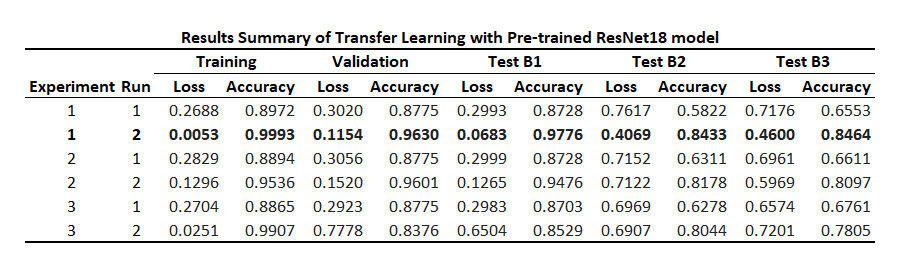

Detailed charts of these results can be seen here: https://wandb.ai/ictprintplex/seed-classification/


## Load the best Transfer Learning CNN model

In [ ]:
# Define the model architecture
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = create_resnet18_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Use the same optimizer and parameters as the best model

# Load the saved state dictionaries
saved_path = "/content/drive/MyDrive/Best-Models/TL_CNN/TL_CNN_best_b1_test_acc_model.pt"
# saved_state = torch.load(saved_path) # use this when running with gpu
saved_state = torch.load(saved_path, map_location=torch.device('cpu')) # use this when running with cpu

exp_name = saved_state['experiment_name']
model.load_state_dict(saved_state['model_state_dict'])
optimizer.load_state_dict(saved_state['optimizer_state_dict'])


In [ ]:
print(exp_name)

## Best TL CNN Model Summary

In [ ]:
# Find the reference to each layer by getting its name
print(model)

In [ ]:
# Print the summary of the model
summary(model, input_size=(3, 256, 256))

## Visualisation

### Sample Images

In [ ]:
# Load image sample for each batch
b1_img_name, b1_image, b1_img_label = test_b1_dataset[0]
b2_img_name, b2_image, b2_img_label = test_b2_dataset[0]
b3_img_name, b3_image, b3_img_label = test_b3_dataset[0]

### Visualise learned weights

We will employ two visualization methods to comprehend the patterns learned by the filters/kernels/weights:

1. Visualizing each channel in a filter independently using a heatmap.
2. Visualizing each filter by combining three channels into an RGB image.

We will focus solely on visualizing the first convolutional layer of the model. As indicated in the [model summary](#scrollTo=RrjCwuy-sLsv) above, this layer comprises 64 filters. To visualize each channel of these filters independently, we need to plot a total of $64*3=192$ individual channel filter plots.

```
(conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
```

As we delve deeper into the network, the number of filters employed for convolution increases. Due to the substantial number of filters, it becomes impractical to visualize all these filter channels individually, either as a single image or each channel separately. For instance, the fifth convolutional layer will entail $64*3=4096$ single-image filters and $64*64*3=12288$ individual channel filter plots.

```
(conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
```

#### Each channel in a filter

In [ ]:
# Method-1: Visualizing each channel in a filter independently using a heatmap
visualize_learned_weights(model, 'conv1', "Conv2d-1", single_channel=True, collated=False)

The output above demonstrates the visualization of each filter channel (RGB) among a total of 64 filters (numbered 0–63), depicted individually. This approach provides a deeper understanding of the specific features different filters aim to capture from the input data.

Examining the visualizations reveals interpretable features such as edges, angles, and boundaries within the images from the initial convolution layer. Notably, the patterns observed in some channels of the same filter vary, indicating that not all channels within a filter seek to learn identical information from the input image.

As we progress deeper into the network, the filter patterns become increasingly complex, tending to capture higher-level information that may be less interpretable for humans.

It's important to note that some patches appear dark while others appear bright. Given that pixel values range from 0 to 255, with 0 representing full black and 255 representing white, darker patches correspond to lower weight values, while brighter patches correspond to higher weight values. Consequently, the model prioritizes areas of the image where the weight values are higher during the element-wise product of the weights with the pixel values.

#### Channels as one RGB image

In [ ]:
# Method-2: Visualizing each filter by combing three channels as an RGB image
visualize_learned_weights(model, 'conv1', "Conv2d-1", single_channel=False)

From the images, we can interpret that the kernels seem to learn blurry edges, contours, boundaries. For example, figure 6 in the above image indicates that the filter is trying to learn the contours of the seed. Similarly, figure 18 seems like the filter has learned about the center seed sprouts.

### Visualise feature maps


Feature maps represents the convolution operation. It is what we get after a filter has passed through the pixel values of an input image. Specifically, it is what the convolutional layer sees after passing the filters on the image.

From the results below, you can see that different filters focus on different aspects while creating the feature map of an image. Some feature maps focus on the background of the image. Some others create an outline of the image. A few filters create feature maps where the background is dark but the image of the seed is bright. This is due to the corresponding weights of the filters.

It is very clear from the results below that in the deep layers, the neural network gets to see very detailed feature maps of the input image, for example see results for [15th Convolution Layer](#scrollTo=oAMnQLxzac5X&line=2&uniqifier=1).

#### 1st Convolution Layer
As observed from the [model summary](#scrollTo=RD18vQeVtzsf&line=1&uniqifier=1), `conv1` is the first convolution layer.

In [ ]:
# B1 Image
visualize_feature_maps(model, b1_image, 'conv1')

In [ ]:
# B2 Image
visualize_feature_maps(model, b2_image, 'conv1')

In [ ]:
# B3 Image
visualize_feature_maps(model, b3_image, 'conv1')

#### 2nd Convolution Layer
As observed from the [model summary](#scrollTo=RD18vQeVtzsf&line=1&uniqifier=1), `layer1.0.conv1` is the second convolution layer.

In [ ]:
# B1 Image
visualize_feature_maps(model, b1_image, 'layer1.0.conv1')

In [ ]:
# B2 Image
visualize_feature_maps(model, b2_image, 'layer1.0.conv1')

In [ ]:
# B3 Image
visualize_feature_maps(model, b3_image, 'layer1.0.conv1')

#### 15th Convolution Layer
As observed from the [model summary](#scrollTo=RD18vQeVtzsf&line=1&uniqifier=1), `layer3.1.conv2` is the fifteenth convolution layer.

In [ ]:
# B1 Image
visualize_feature_maps(model, b1_image, 'layer3.1.conv2')

In [ ]:
# B2 Image
visualize_feature_maps(model, b2_image, 'layer3.1.conv2')

In [ ]:
# B3 Image
visualize_feature_maps(model, b3_image, 'layer3.1.conv2')

### Visualise the saliency map

Saliency maps are used to highlight the parts of an image that were most relevant in the decision-making process of the model. They give us an idea of what the model is focusing on when making a prediction, as well as reveal where the model is weak and makes mistakes.

We have implemented both the Vanilla Saliency Map as well Guided Saliency Map. As you will notice from the results below, Guided Saliency Map helps to remove noisy and irrelevant information from the saliency map and retain only the information that is relevant to the final output.

**Note for a known bug:** the global hook/handle that's registered for performing guided backpropagation for saliency maps is not being unregistered properly (still unsure if this a problem with pytorch e.g., [(1)](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_backward_hook), [(2)](https://discuss.pytorch.org/t/backward-hook-not-called/95942/3) [(3)]( https://discuss.pytorch.org/t/how-to-remove-multiple-hooks/135442) or our code). Thus, if you set `guided=False` for vanilla saliency map again after running the guided saliency map, the output generated is of guided saliency map but it should be vanilla saliency map.
For the time being, the solution is create a [new model](#scrollTo=c19r2389jArp&line=1&uniqifier=1) and then set `guided=False` for vanilla saliency map.

#### Vanilla Saliency Map

In [ ]:
# B1 Image
visualize_saliency_map(model, b1_image, guided=False)

In [ ]:
# B2 Image
visualize_saliency_map(model, b2_image, guided=False)

In [ ]:
# B3 Image
visualize_saliency_map(model, b3_image, guided=False)

#### Guided Saliency Map

From the results below you can clearly observe that for these seeds the model is detecting the dark spots on the seed sprouts to make its prediction. For [B3 sample](#scrollTo=c4ARAoL5CLsL&line=2&uniqifier=1), we can also observe the model faintly recognised the dents in the seed.

In [ ]:
print(b1_img_name)
print(b2_img_name)
print(b3_img_name)

In [ ]:
# B1 Image
visualize_saliency_map(model, b1_image, guided=True)

In [ ]:
# B2 Image
visualize_saliency_map(model, b2_image, guided=True)

In [ ]:
# B3 Image
visualize_saliency_map(model, b3_image, guided=True)

# Discussion

## Challenges

* As discussed earlier in the [results](#scrollTo=FABKyUTdg9z7) section, a consistent trend observed in the performance of both our trained models is that Tests on B1 consistently outperform Tests on B2 and B3. This trend is evident in both the simple and more complex pretrained models. Consequently, there is limited benefit in attempting to increase model complexity or prevent overfitting on B1 using regularization techniques. In fact, such efforts may potentially degrade performance beyond a certain threshold.

  The primary issue stems from the fact that the model has been exclusively trained on B1 images, resulting in learning features specific to B1.

## Solutions

* One straightforward and efficient approach to tackle this issue is by amalgamating the images from B1, B2, and B3 into a unified dataset. By exposing the model to examples from each batch during training, it can learn features that are common across all three batches, thereby enhancing its potential for generalization.

* Alternatively, we can employ domain adaptation techniques to bridge the disparity between the source domain (B1) and the target domains (B2 and B3). Domain adaptation, a specialized form of transfer learning, addresses the challenge of adapting a model trained on one domain to another domain with differences that hinder direct application of the model. In this scenario, the variations in image distributions among B1, B2, and B3 arise from differing lighting conditions.

  * Utilizing data augmentation methods, such as brightness and contrast adjustments, enables us to simulate the lighting conditions present in B2 and B3. This enables the model to learn to discern features under diverse lighting conditions, thereby enhancing its generalization capacity.

  * Expanding upon data augmentation, we can implement more sophisticated techniques like adversarial training. In adversarial training, a discriminator is trained to distinguish between the source and target domains, while the classifier is trained to confuse the discriminator. This encourages the model to learn features that remain invariant across domains. The resulting augmented architecture can be trained using standard backpropagation and stochastic gradient descent to classify images as either Bad or Good Seeds.



# Adversarial Training for Domain Adaptation

**Adversarial Training for Domain Adaptation: Overview**

1. **Train a Feature Extractor**: Utilize a neural network, typically a Convolutional Neural Network (CNN), to extract features from images. This feature extractor serves as the shared component of the model for both the source and target domains.

2. **Train a Domain Classifier**: Train a separate neural network, often a fully connected network, to classify the domain of input images (e.g., belonging to B1, B2, or B3) based on the features extracted by the feature extractor.

3. **Train a Label Classifier**: Train another neural network to predict the actual labels of input images (e.g., object categories) based on the features extracted by the feature extractor.

4. **Adversarial Training**: During training, optimize the feature extractor and label classifier to minimize the classification loss on labeled source domain data (e.g., B1). Simultaneously, train the feature extractor and domain classifier in an adversarial manner: the feature extractor aims to maximize the domain classification loss, while the domain classifier aims to minimize it. This adversarial setup compels the feature extractor to learn features that are invariant across domains, as it attempts to "confuse" the domain classifier.